# Natural Language Processing: Week 4 - Sequence models and literature

앞서 배운 Sequence Model을 이용하여 새로운 text를 생성하는 것을 생각해보자.

이는 굉장히 어렵고 새로운 것처럼 보이지만, 사실 이에 필요한 모든 것을 우리는 이미 배웠다.

새로운 것을 생성하는 것이 아니라, '다음에 올 단어를 예측'하는 예측 문제라고 생각해보자. 전체 phrase로부터 단어들을 추출해 dataset을 형성한 후 X라는 만들어진 phrase와 그 뒤에 올 Y를 예측해나가면 된다.

많은 단어들을 이용하여 신경망을 학습시킨다면 꽤나 복잡한 문장 또한 생성할 수 있을 것이다.

## Lab01

### Import packages

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

### Tokenizer and data


In [2]:
tokenizer = Tokenizer()

data="In the town of Athy one Jeremy Lanigan \nBattered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [3]:
print(tokenizer.word_index)
print(total_words)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

In [4]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [5]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

4
2
66
8
67
68
69
70


In [6]:
print(xs[5])
print(ys[5])

[ 0  0  0  0  4  2 66  8 67 68]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
print(tokenizer.word_index)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

In [8]:
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(LSTM(20))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=500, verbose=1)

Epoch 1/500
15/15 [==============================] - 7s 8ms/step - loss: 5.5686 - accuracy: 0.0155
Epoch 2/500
15/15 [==============================] - 0s 7ms/step - loss: 5.5481 - accuracy: 0.0530
Epoch 3/500
15/15 [==============================] - 0s 8ms/step - loss: 5.5006 - accuracy: 0.0309
Epoch 4/500
15/15 [==============================] - 0s 8ms/step - loss: 5.3891 - accuracy: 0.0199
Epoch 5/500
15/15 [==============================] - 0s 8ms/step - loss: 5.2637 - accuracy: 0.0199
Epoch 6/500
15/15 [==============================] - 0s 8ms/step - loss: 5.1751 - accuracy: 0.0486
Epoch 7/500
15/15 [==============================] - 0s 8ms/step - loss: 5.1195 - accuracy: 0.0486
Epoch 8/500
15/15 [==============================] - 0s 8ms/step - loss: 5.0792 - accuracy: 0.0486
Epoch 9/500
15/15 [==============================] - 0s 8ms/step - loss: 5.0504 - accuracy: 0.0486
Epoch 10/500
15/15 [==============================] - 0s 9ms/step - loss: 5.0201 - accuracy: 0.0486
Epoch 11/

### Visualize

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

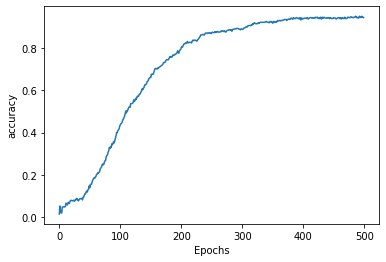

In [10]:
plot_graphs(history, 'accuracy')

### Generate new text

In [11]:
seed_text = "Laurence went to dublin"
next_words = 10

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # in TF 2.5.x
  # predicted = model.predict_classes(token_list, verbose=0) 

  # in TF 2.6 above
  predict_x = model.predict(token_list, verbose=0)
  predicted=np.argmax(predict_x,axis=1)

  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

Laurence went to dublin all merry and i we banished their nonsense ask brothers


## Finding what the next word should be

앞선 실습에서, 우리는 단일 가사가 포함된 문자열 데이터를 통해 새 텍스트를 생성하기 위해 데이터를 준비하는 방법에 대해 알아봤다. 

우리는 데이터를 토큰화하고 문장의 다음 단어로 표시된 하위 문장 조각들을 만들고, 라벨을 원핫 인코딩하여 신경망을 구축할 수 있도록 했다. 

이로 인해 생성된 문장을 살펴보면, 상당히 많은 단어가 중복적으로 나타남을 알 수 있는데, 이는 LSTM이 context를 단순히 forward 방향으로만 이동시키기 때문이라고 할 수 있다.

LSTM 부분에 Bidirectional을 추가하면 조금 더 자연스러운 문장을 얻을 수 있다

In [12]:
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=500, verbose=1)

Epoch 1/500
15/15 [==============================] - 4s 11ms/step - loss: 5.5688 - accuracy: 0.0088
Epoch 2/500
15/15 [==============================] - 0s 11ms/step - loss: 5.5443 - accuracy: 0.0552
Epoch 3/500
15/15 [==============================] - 0s 11ms/step - loss: 5.4949 - accuracy: 0.0508
Epoch 4/500
15/15 [==============================] - 0s 10ms/step - loss: 5.3480 - accuracy: 0.0508
Epoch 5/500
15/15 [==============================] - 0s 11ms/step - loss: 5.1504 - accuracy: 0.0508
Epoch 6/500
15/15 [==============================] - 0s 11ms/step - loss: 5.0681 - accuracy: 0.0508
Epoch 7/500
15/15 [==============================] - 0s 11ms/step - loss: 5.0311 - accuracy: 0.0508
Epoch 8/500
15/15 [==============================] - 0s 11ms/step - loss: 4.9965 - accuracy: 0.0508
Epoch 9/500
15/15 [==============================] - 0s 10ms/step - loss: 4.9647 - accuracy: 0.0530
Epoch 10/500
15/15 [==============================] - 0s 10ms/step - loss: 4.9267 - accuracy: 0.0596

In [13]:
seed_text = "Laurence went to dublin"
next_words = 10

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predict_x = model.predict(token_list, verbose=0)
  predicted=np.argmax(predict_x,axis=1)

  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

Laurence went to dublin leg nice left the kerrigan fainted the swore strangled youd


이전보다 훨씬 나은 문장이 생성되었음을 확인할 수 있다.

여전히 반복이 있고 어색한 부분이 있지만, 이는 우리가 데이터로써 넣어준 문장이 곡 가사이기 때문이라 할 수도 있다.

또한, 문장 생성은 뒤로 갈 수록, 생성된 데이터에 대한 새로운 예측이기 때문에 문장이 길어질 수록 정확도가 떨어지는 문제도 있다.

위 코드에서, 사용된 데이터를 바꾸어 더 나은 문장을 생성할 수 있도록 해보자.

## Lab02

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
tokenizer = Tokenizer()
path = '/content/drive/MyDrive/data'
data = open(f'{path}/Laurences_generated_poetry.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

In [16]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [17]:
# large corpus에 대해 더 잘 동작할 수 있도록 model 수정
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150))) # increase units
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate = 0.01) # use own optimizer
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=500, verbose=1)

Epoch 1/500
377/377 [==============================] - 11s 19ms/step - loss: 6.6500 - accuracy: 0.0714
Epoch 2/500
377/377 [==============================] - 7s 19ms/step - loss: 5.7676 - accuracy: 0.1141
Epoch 3/500
377/377 [==============================] - 7s 19ms/step - loss: 4.8700 - accuracy: 0.1699
Epoch 4/500
377/377 [==============================] - 7s 19ms/step - loss: 3.9243 - accuracy: 0.2446
Epoch 5/500
377/377 [==============================] - 7s 19ms/step - loss: 3.0836 - accuracy: 0.3530
Epoch 6/500
377/377 [==============================] - 7s 19ms/step - loss: 2.4078 - accuracy: 0.4531
Epoch 7/500
377/377 [==============================] - 7s 18ms/step - loss: 1.9189 - accuracy: 0.5515
Epoch 8/500
377/377 [==============================] - 7s 19ms/step - loss: 1.5388 - accuracy: 0.6359
Epoch 9/500
377/377 [==============================] - 7s 18ms/step - loss: 1.3045 - accuracy: 0.6927
Epoch 10/500
377/377 [==============================] - 7s 19ms/step - loss: 1.15

### Visualize

In [18]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

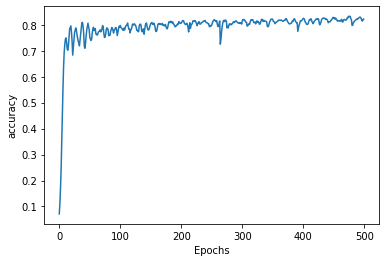

In [19]:
plot_graphs(history, 'accuracy')

In [20]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predict_x = model.predict(token_list, verbose=0)
  predicted=np.argmax(predict_x,axis=1)

  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

I've got a bad feeling about this cruel law agin there at night i so i gone at the bower oer gone alas like love sends short your eyes glisten eyes far eily stealing by a art damsel windows heaven rosie kilrain december talk of athy one jeremy lanigan sanctified by the five hunt five hunt hoping i town stuck from fishers gone gone alas i jig taxes murray forbid love wandered on now on sober shannon gone i glens with regard the village church stands near mairis died without bellows chanters and kilrush right law clare o gone distant blame pure crystal fountain gone your eyes


위 작업은 데이터의 양이 클수록 좋은 성능을 낼 것이라고 기대할 수 있다.

하지만 위와 같이 원핫 인코딩 방식으로는 데이터가 굉장히 커질 경우 메모리가 부족해지는 현상이 일어날 수 있어, 이를 방지할 수 있는 다른 방법을 찾는 것이 필요해보인다.

그 방법을 다음 실습에서 진행해보도록 하겠다.

## Additional: Generating text using a character-based RNN
[공식문서 링크](https://www.tensorflow.org/text/tutorials/text_generation)

</br>

여기서 우리는, character-based RNN을 이용해서 text를 생성하는 방법을 알아볼 것이다.

데이터셋으로는, Andrej Karpathy의 [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)에서 사용된 셰익스피어의 글을 이용할 것이다.

문자 시퀀스의 다음 '문자'를 예측하도록 모델을 학습시키는 것이 해당 실습의 메인 아이디어이다. 모델을 반복적으로 호출하면 더 긴 텍스트 시퀀스를 생성할 수 있다.



다음은 해당 모델을 30epochs로 학습시킨 후 Q 문자를 넣어주어 생성한 예시문이다.

    QUEENE:
    I had thought thou hadst a Roman; for the oracle,
    Thus by All bids the man against the word,
    Which are so weak of care, by old care done;
    Your children were in your holy love,
    And the precipitation through the bleeding throne.

    BISHOP OF ELY:
    Marry, and will, my lord, to weep in such a one were prettiest;
    Yet now I was adopted heir
    Of the world's lamentable day,
    To watch the next way with his father with his face?

    ESCALUS:
    The cause why then we are all resolved more sons.

    VOLUMNIA:
    O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
    And love and pale as any will to that word.

    QUEEN ELIZABETH:
    But how long have I heard the soul for this world,
    And show his hands of life be proved to stand.

    PETRUCHIO:
    I say he look'd on, if I must be content
    To stay him from the fatal of our country's bliss.
    His lordship pluck'd from this sentence then for prey,
    And then let us twain, being the moon,
    were she such a case as fills m

물론 모델이 단어의 의미를 학습한 것은 아니기 때문에 대부분의 문장이 문법적으로는 올바르지 않다. 하지만 모델이 학습을 시작할 때, 모델은 해당 영단어를 발음하는 방법은 커녕, 만들어진 문자집합이 단어를 이루는지조차 알지 못하는 것을 고려할 때, 굉장히 완성도 있음을 확인할 수 있다.

또한, 셰익스피어의 연극대본 형태의 글을 학습하였기에 각 블록은 대문자로 표시된 화자의 이름 뒤에 위치하고 있는 것을 확인할 수 있다.

### Import packages

In [21]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os
import time

### Prepare for the Shakespeare dataset

In [22]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1130496/1115394 [==============================] - 0s 0us/step


In [23]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [24]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [25]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### Process the text

In [26]:
# Vectorize the text: String -> Numerical representation
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [27]:
# The preprocessing.StringLookup layer can convert each character into a numeric ID
ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [28]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [29]:
# representation to human=readable strings
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [30]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [31]:
# join the characters back into strings
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [32]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Prediction

모델에 대한 입력은 문자 시퀀스가 되고, 모델은 다음에 올 문자를 예측하게 된다. 위에서와 마찬가지로 일종의 예측 문제라고 볼 수 있는 것이다.

In [33]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [34]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [35]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [36]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

batch 메서드는 개별 문자를 특정 사이즈의 sequence로 바꾸는 작업을 수월하게 만들어준다.

In [37]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [38]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


모델 학습을 위해, 우리는 input과 label을 가지는 데이터셋을 필요로 한다. 여기서의 input과 label은 sequences이다.

각 단계마다 input은 현재 문자이고 label은 다음 문자가 된다.

In [41]:
# shifts input to align with label for each time step
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [42]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [43]:
dataset = sequences.map(split_input_target)

In [44]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Create training batches

`tf.data`를 이용해서 text를 manageable한 sequence로 바꾸도록 하자.

data를 모델에 feeding하기 전에, data를 shuffle하고 이를 batch에 pack하는 과정이 필요하다.

In [45]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

### Build the Model

해당 모델은 3개의 레이어로 이루어진다.

- `tf.keras.layers.Embedding`: input layer. 각 character-ID를 `embedding_dim` 차원의 벡터로 매핑하는 trainable lookup table

- `tf.keras.layers.GRU`: `units=rnn_units` 사이즈의 RNN의 일종 (대신 LSTM 사용 가능)

- `tf.keras.layers.Dense`: output layer. `vocab_size`의 output 출력. character 당 하나의 logit을 출력

In [46]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [47]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

~~모델을 class로 정의하는 방법 기억할 것~~

In [48]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

각 character는 모델에 의해 embedding되고, 해당 embedding을 input으로 timestep마다 GRU를 실행시킨다. 이것은 Dense layer에 apply되어 다음 문자의 log-likelihood를 예측하는 logit을 출력한다.

![image](https://user-images.githubusercontent.com/76294398/141275287-5460b3f1-f137-40eb-8d59-e909393cb38c.png)


### Train the Model

여기서, loss function은 prediction의 마지막 차원을 거쳐 적용될 것이므로, `tf.keras.losses.sparse_categorical_crossentropy`가 loss function으로써 사용될 것이다.

In [49]:
# check the shape of the output
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [50]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_3 (Dense)             multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [51]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [52]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         4.1894884


In [53]:
tf.exp(mean_loss).numpy()

65.98902

In [54]:
model.compile(optimizer='adam', loss=loss)

#### Configure Checkpoints

`tf.keras.callbacks.ModelCheckpoint`를 이용해 training 과정 중 checkpoint가 save되도록 하자.

In [56]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [57]:
EPOCHS = 20

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 27s 136ms/step - loss: 2.7273
Epoch 2/20
172/172 [==============================] - 25s 134ms/step - loss: 1.9907
Epoch 3/20
172/172 [==============================] - 25s 136ms/step - loss: 1.7102
Epoch 4/20
172/172 [==============================] - 25s 136ms/step - loss: 1.5478
Epoch 5/20
172/172 [==============================] - 25s 136ms/step - loss: 1.4487
Epoch 6/20
172/172 [==============================] - 25s 136ms/step - loss: 1.3807
Epoch 7/20
172/172 [==============================] - 25s 135ms/step - loss: 1.3276
Epoch 8/20
172/172 [==============================] - 25s 135ms/step - loss: 1.2824
Epoch 9/20
172/172 [==============================] - 25s 135ms/step - loss: 1.2412
Epoch 10/20
172/172 [==============================] - 25s 135ms/step - loss: 1.2007
Epoch 11/20
172/172 [==============================] - 25s 136ms/step - loss: 1.1612
Epoch 12/20
172/172 [==============================] - 25s 136ms/step - lo

### Generate text

해당 모델을 통해 text를 생성하는 가장 간단한 방법은 loop를 실행시키고 그 전반에 internal state가 전파되게 하는 것이다.

![image](https://user-images.githubusercontent.com/76294398/141276770-ba93cb7c-0aeb-4542-bf2e-0f099d990177.png)

In [58]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [59]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [60]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Nay, then I see him soon look'd fate, nothing
should see me an imagine.

Servant:
He hearly yet unborn! vent-hold death.

ABHORSON:
Come on: warlike spenct, as the dost now, sweet Kate, one ground
And bear thee treth, and I can none with her.
Upon this son shall lie in peradain?
Most mighty, you have left unquisadors,
Nor though for Rome, may less thee,
To move my business, and all this linely
letter us here for Edward; and their souls--
As you have early bough as approaches
As if they who, any chance to sleep shows more,
Such as she is not four thressed hit himself.

YORK:
Think you you think I can tell you alone? let's peru
With this excellent blood for both, frightlongs, beseech
you.

CORIOLANUS:
Let me give what thou queen, you know; for I
will secret me to swear courtier.

Second Lady:
Blue, here comes the world's threats?

TYBALT:
Look I heart is seated, and after players
All in reversion her consent,
As Priuse of Careshul with a tormour of a woman
Cass'd it will a serpthe

In [61]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThat is that thinks you have in dried; for they\nnot pick'd in blood out at mine honest house.\n\nESCALUS:\nI am the lark, that know me now:\nGo thou to Full ase you lore's toad.\nThis cannot guls fortune both to claim?\nI saw, tempt with me in her issiee,\nThe matter out o' dost thou wast before 's.\n\nJULIET:\nIt told me not, whick, thou repliest! a mighty power,\nEre we let no other heir to answer.\n\nPETRUCHIO:\nWhere bite an uneapant give?\n\nJULIET:\nNature till now Elbow her that did never lead each carp,\nThat getted us in pomp, distrain'd here,\nOur strength as white until death waste griefs,\nLike wom, and surge the church to the roof of a\nsweeter's eye, from his own goodness ir he,\nCass on the hardle old and not upon my hands,\nNeing to be soon look on no way of beasts!\n\nRICHARD:\nBreak of our mind, teach me how to the cast.\n\nEDWARD:\nI am a peril to incert them to\nHortensio to ask him to the world.\n\nVIRGILIA:\nI think he were to tell him thy\n

### Export the Generator

이 single-step model은 `tf.saved_model`을 통해 손쉽게 save되고 restore될 수 있다.

In [62]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

INFO:tensorflow:Assets written to: one_step/assets


INFO:tensorflow:Assets written to: one_step/assets


In [63]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
This widow'st two lady stroke and loves to hear
Chatering arguments of pity, you have
must sea nor 


### Advanced: Customized Training

위의 훈련과정은 간단하지만, 높은 자율성을 제공하지는 않는다. 

잘못된 예측이 모델에 피드백되는 것을 방지하는 teacher-forcing 기능을 사용하기 때문에 모델은 실수로부터 복구하는 법을 배우지 못한다.

이제 모델을 수동으로 실행하는 방법에 대해 알아보았으니 training loop를 구현할 것이다. 

Customized training loop의 가장 중요한 부분은 train 부분 함수입니다.

`tf.GradientTape`를 사용하여 그라디언트를 추적한다. 

기본 절차는 다음과 같다.

1. 모델을 실행하고 `tf.GradientTape`를 이용해 loss를 계산
2. 업데이트를 계산하고 Optimizer를 사용하여 모델에 적용

In [64]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [65]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [66]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [67]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 27s 136ms/step - loss: 2.7414


In [68]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1506
Epoch 1 Batch 50 Loss 2.0763
Epoch 1 Batch 100 Loss 1.9530
Epoch 1 Batch 150 Loss 1.8628

Epoch 1 Loss: 2.0064
Time taken for 1 epoch 25.39 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8157
Epoch 2 Batch 50 Loss 1.7655
Epoch 2 Batch 100 Loss 1.7070
Epoch 2 Batch 150 Loss 1.6554

Epoch 2 Loss: 1.7280
Time taken for 1 epoch 24.43 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6172
Epoch 3 Batch 50 Loss 1.5649
Epoch 3 Batch 100 Loss 1.5220
Epoch 3 Batch 150 Loss 1.5328

Epoch 3 Loss: 1.5651
Time taken for 1 epoch 24.47 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4930
Epoch 4 Batch 50 Loss 1.4155
Epoch 4 Batch 100 Loss 1.4574
Epoch 4 Batch 150 Loss 1.4524

Epoch 4 Loss: 1.4627
Time taken for 1 epoch 24.42 sec
_____________________________________________________________________